# Alpha Excel v2.0 Tutorial

이 노트북은 alpha-excel v2.0의 핵심 기능을 간단하게 소개합니다.

## 주요 특징
- **즉시 실행 (Eager Execution)**: 연산이 즉시 실행됨
- **타입 인식 시스템**: numeric, group, weight, mask 타입별 자동 전처리
- **메서드 기반 API**: import 없이 IDE 자동완성 지원
- **캐시 상속**: 상위 단계의 캐시를 하위 단계에서 접근 가능
- **설정 기반 설계**: YAML 파일로 동작 제어

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 프로젝트 루트를 path에 추가
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

from alpha_excel2.core.facade import AlphaExcel

## 1. AlphaExcel 초기화

시작일과 종료일을 지정하여 AlphaExcel 인스턴스를 생성합니다.

In [2]:
ae = AlphaExcel(
    start_time='2023-01-29',
    end_time='2023-02-28',
    universe=None,
    config_path='../config'
)

print(f"Time Range: {ae._start_time} to {ae._end_time}")
print(f"Universe Shape: {ae._universe_mask._data.shape}")

Time Range: 2023-01-29 00:00:00 to 2023-02-28 00:00:00
Universe Shape: (22, 2477)


## 2. 사용 가능한 연산자 확인

카테고리별로 등록된 연산자를 확인합니다.

In [3]:
o = ae.ops

by_category = o.list_operators_by_category()
for category, ops in sorted(by_category.items()):
    print(f"\n{category}:")
    for op in ops:
        print(f"  - {op}")


crosssection:
  - rank

group:
  - group_rank

timeseries:
  - ts_mean


## 3. 데이터 필드 로딩

서로 다른 타입의 필드를 로딩합니다:
- `fnguide_market_cap`: numeric 타입 (시가총액)
- `returns`: numeric 타입 (수익률)
- `fnguide_sector`: group 타입 (섹터)

In [4]:
f = ae.field

# 시가총액 로딩
cap = f('fnguide_market_cap')
print("[Market Cap]")
print(f"Data type: {cap._data_type}")
print(cap.to_df().iloc[:10, :10])

[Market Cap]
Data type: numeric
symbol           A000020       A000040       A000050       A000060  \
date                                                                 
2023-01-30  2.606010e+11  5.162600e+10  2.914240e+11  5.732970e+12   
2023-01-31  2.619970e+11  5.105000e+10  2.933430e+11  5.732970e+12   
2023-02-01  2.633940e+11  5.095300e+10  2.944400e+11  5.732970e+12   
2023-02-02  2.647900e+11  5.114600e+10  2.982780e+11  5.732970e+12   
2023-02-03  2.625560e+11  5.191500e+10  3.001970e+11  5.732970e+12   
2023-02-06  2.633940e+11  5.210700e+10  3.040350e+11  5.732970e+12   
2023-02-07  2.673040e+11  5.229900e+10  3.012940e+11  5.394012e+12   
2023-02-08  2.647900e+11  5.191500e+10  2.982780e+11  5.394012e+12   
2023-02-09  2.650700e+11  5.191500e+10  2.996490e+11  5.394012e+12   
2023-02-10  2.633940e+11  5.095300e+10  2.966330e+11  5.394012e+12   

symbol           A000070       A000080       A000100       A000120  \
date                                                     

In [5]:
# 수익률 로딩
ret = f('returns')
print("[Returns]")
print(f"Data type: {ret._data_type}")
print(ret.to_df().iloc[:10, :10])

[Returns]
Data type: numeric
symbol       A000020   A000040   A000050  A000060   A000070   A000080  \
date                                                                    
2023-01-30  0.004306 -0.005135  0.000000      0.0  0.002801  0.003861   
2023-01-31  0.005359 -0.011613  0.006585      0.0  0.004190  0.011538   
2023-02-01  0.005330 -0.001305  0.003738      0.0  0.002782 -0.011407   
2023-02-02  0.005302  0.003268  0.013035      0.0  0.004161  0.000000   
2023-02-03 -0.008439  0.014984  0.006434      0.0  0.000000  0.005769   
2023-02-06  0.003191  0.003851  0.012785      0.0  0.002762 -0.001912   
2023-02-07  0.014846  0.003836 -0.009017      0.0  0.045455 -0.007663   
2023-02-08 -0.009404 -0.007643 -0.010009      0.0 -0.042161 -0.001931   
2023-02-09  0.001055  0.000000  0.004596      0.0 -0.013755 -0.003868   
2023-02-10 -0.006322 -0.017972 -0.010064      0.0 -0.004184 -0.007767   

symbol       A000100   A000120   A000140   A000150  
date                                     

In [6]:
# 섹터 로딩
sector = f('fnguide_sector')
print("[Sector]")
print(f"Data type: {sector._data_type}")
print(sector.to_df().iloc[:10, :10])

[Sector]
Data type: group
symbol     A000020 A000040 A000050 A000060 A000070 A000080 A000100 A000120  \
date                                                                         
2023-01-30     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2023-01-31      의료   경기소비재   경기소비재      금융      소재   필수소비재      의료     산업재   
2023-02-01      의료   경기소비재   경기소비재      금융      소재   필수소비재      의료     산업재   
2023-02-02      의료   경기소비재   경기소비재      금융      소재   필수소비재      의료     산업재   
2023-02-03      의료   경기소비재   경기소비재      금융      소재   필수소비재      의료     산업재   
2023-02-06      의료   경기소비재   경기소비재      금융      소재   필수소비재      의료     산업재   
2023-02-07      의료   경기소비재   경기소비재      금융      소재   필수소비재      의료     산업재   
2023-02-08      의료   경기소비재   경기소비재      금융      소재   필수소비재      의료     산업재   
2023-02-09      의료   경기소비재   경기소비재      금융      소재   필수소비재      의료     산업재   
2023-02-10      의료   경기소비재   경기소비재      금융      소재   필수소비재      의료     산업재   

symbol     A000140 A000150  
date    

## 4. 시계열 연산 및 모멘텀 시그널 생성

이동평균을 계산하고 모멘텀 시그널을 생성합니다.

In [7]:
# 3일 이동평균 (캐시 기록)
ma3 = o.ts_mean(ret, window=3, record_output=True)

# 5일 이동평균
ma5 = o.ts_mean(ret, window=5)

# 모멘텀 = ma3 - ma5
momentum = ma3 - ma5

print("[Momentum Signal]")
print(momentum.to_df().head(10))

[Momentum Signal]
symbol       A000020   A000040   A000050  A000060   A000070   A000080  \
date                                                                    
2023-01-30       NaN       NaN       NaN      NaN       NaN       NaN   
2023-01-31  0.000000  0.000000  0.000000      0.0  0.000000  0.000000   
2023-02-01  0.000000  0.000000  0.000000      0.0  0.000000  0.000000   
2023-02-02  0.000256  0.000479  0.001947      0.0  0.000227 -0.000954   
2023-02-03 -0.001640  0.005609  0.001777      0.0 -0.000473 -0.003832   
2023-02-06 -0.002131  0.005531  0.002236      0.0 -0.000471  0.000488   
2023-02-07 -0.000847  0.002630 -0.001994      0.0  0.005040  0.001774   
2023-02-08  0.001778 -0.003644 -0.004726      0.0 -0.000025 -0.002688   
2023-02-09  0.001916 -0.004275 -0.005768      0.0 -0.001947 -0.002566   
2023-02-10 -0.005564 -0.004953 -0.002817      0.0 -0.017657  0.000106   

symbol       A000100   A000120   A000140   A000150  ...   A950110   A950130  \
date                      

## 5. 그룹 연산: 섹터 내 순위

각 섹터 내에서 모멘텀 시그널의 순위를 계산합니다.

In [8]:
signal = o.group_rank(momentum, sector)

print("[Group Rank Signal]")
print(signal.to_df().head(10))

[Group Rank Signal]
symbol       A000020   A000040   A000050   A000060   A000070   A000080  \
date                                                                     
2023-01-30       NaN       NaN       NaN       NaN       NaN       NaN   
2023-01-31  0.501623  0.501155  0.501155  0.503226  0.501887  0.502924   
2023-02-01  0.501623  0.501155  0.501155  0.503226  0.501887  0.502924   
2023-02-02  0.165584  0.355658  0.482679  0.322581  0.188679  0.181287   
2023-02-03  0.168831  0.720554  0.512702  0.361290  0.260377  0.099415   
2023-02-06  0.454545  0.836028  0.660508  0.483871  0.452830  0.415205   
2023-02-07  0.737013  0.806005  0.494226  0.635484  0.913208  0.766082   
2023-02-08  0.847403  0.307159  0.258661  0.500000  0.494340  0.350877   
2023-02-09  0.464286  0.173210  0.131640  0.396774  0.339623  0.304094   
2023-02-10  0.181818  0.217090  0.334873  0.435484  0.026415  0.555556   

symbol       A000100   A000120   A000140   A000150  ...   A950110   A950130  \
date        

## 6. 시그널 히스토리 및 캐시 확인

각 단계의 연산 히스토리와 캐시를 확인합니다.

In [11]:
# 마지막 단계의 히스토리
print("\nStep -1:")
print(signal._step_history[-1])


Step -1:
{'step': 3, 'expr': 'GroupRank((TsMean(Field(returns), window=3) - TsMean(Field(returns), window=5)), Field(fnguide_sector))', 'op': 'GroupRank'}


In [16]:
# 캐시 정보
print("[Cache Information]")
print(f"Step Counter: {signal._step_counter}")
print(f"Cache Size: {len(signal._cache)}")
print(f"\nCached Steps:")
signal._cache[0]

[Cache Information]
Step Counter: 3
Cache Size: 1

Cached Steps:


CachedStep(step=1, name='TsMean(Field(returns), window=3)', data=symbol       A000020   A000040   A000050  A000060   A000070   A000080  \
date                                                                    
2023-01-30  0.004306 -0.005135  0.000000      0.0  0.002801  0.003861   
2023-01-31  0.004832 -0.008374  0.003293      0.0  0.003496  0.007700   
2023-02-01  0.004998 -0.006018  0.003441      0.0  0.003258  0.001331   
2023-02-02  0.005331 -0.003217  0.007786      0.0  0.003711  0.000044   
2023-02-03  0.000731  0.005649  0.007736      0.0  0.002314 -0.001879   
2023-02-06  0.000018  0.007368  0.010752      0.0  0.002308  0.001286   
2023-02-07  0.003200  0.007557  0.003401      0.0  0.016072 -0.001269   
2023-02-08  0.002878  0.000015 -0.002080      0.0  0.002019 -0.003835   
2023-02-09  0.002166 -0.001269 -0.004810      0.0 -0.003487 -0.004487   
2023-02-10 -0.004891 -0.008538 -0.005159      0.0 -0.020033 -0.004522   
2023-02-13 -0.001756 -0.010566  0.000642      0.0 -0.006447

## 7. 백테스팅: 가중치 스케일러 설정

DollarNeutral 스케일러를 사용하여 롱-숏 포트폴리오를 구성합니다.

In [19]:
# 스케일러 설정
ae.set_scaler('DollarNeutral')

print("[Scaler Configuration]")
print(f"Scaler Type: {ae._scaler_manager._active_scaler.__class__.__name__}")
print(f"Gross Exposure: {ae._scaler_manager._active_scaler.gross}")
print(f"Net Exposure: {ae._scaler_manager._active_scaler.net}")

[Scaler Configuration]
Scaler Type: DollarNeutralScaler
Gross Exposure: 2.0
Net Exposure: 0.0


## 8. 시그널을 가중치로 변환

시그널을 포트폴리오 가중치로 변환합니다.

In [20]:
weights = ae.to_weights(signal)

print("[Portfolio Weights]")
print(weights.to_df().iloc[:10, :5])

# 가중치 검증
weights_df = weights.to_df()
print(f"\nMean Gross Exposure: {weights_df.abs().sum(axis=1).mean():.4f}")
print(f"Mean Net Exposure: {weights_df.sum(axis=1).mean():.6f}")

[Portfolio Weights]
symbol       A000020   A000040   A000050   A000060   A000070
date                                                        
2023-01-30  0.000000  0.000000  0.000000  0.000000  0.000000
2023-01-31 -0.000259 -0.000536 -0.000536  0.000687 -0.000104
2023-02-01 -0.000259 -0.000536 -0.000536  0.000687 -0.000103
2023-02-02 -0.001110 -0.000483 -0.000064 -0.000592 -0.001034
2023-02-03 -0.001099  0.000721  0.000035 -0.000464 -0.000797
2023-02-06 -0.000157  0.001102  0.000523 -0.000060 -0.000162
2023-02-07  0.000775  0.001003 -0.000026  0.000440  0.001356
2023-02-08  0.001139 -0.000643 -0.000803 -0.000007 -0.000025
2023-02-09 -0.000125 -0.001085 -0.001222 -0.000347 -0.000536
2023-02-10 -0.001056 -0.000940 -0.000552 -0.000220 -0.001569

Mean Gross Exposure: 1.9091
Mean Net Exposure: 0.000000


## 9. 포트폴리오 수익률 계산

가중치와 수익률을 곱하여 포트폴리오 수익률을 계산합니다.

In [21]:
port_returns = ae.to_portfolio_returns(weights)

print("[Portfolio Returns]")
print(port_returns.to_df().iloc[:10, :5])

[Portfolio Returns]
symbol           A000020       A000040       A000050  A000060       A000070
date                                                                       
2023-01-30           NaN           NaN           NaN      NaN           NaN
2023-01-31  0.000000e+00 -0.000000e+00  0.000000e+00      0.0  0.000000e+00
2023-02-01 -1.382857e-06  6.999436e-07 -2.004325e-06      0.0 -2.889485e-07
2023-02-02 -1.372592e-06 -1.750161e-06 -6.981091e-06      0.0 -4.300462e-07
2023-02-03  9.366501e-06 -7.236210e-06 -4.113648e-07     -0.0 -0.000000e+00
2023-02-06 -3.508150e-06  2.775620e-06  4.487500e-07     -0.0 -2.202318e-06
2023-02-07 -2.327027e-06  4.226278e-06 -4.712939e-06     -0.0 -7.381818e-06
2023-02-08 -7.288664e-06 -7.663254e-06  2.587039e-07      0.0 -5.717995e-05
2023-02-09  1.201826e-06 -0.000000e+00 -3.690339e-06     -0.0  3.504376e-07
2023-02-10  7.878480e-07  1.949532e-05  1.229729e-05     -0.0  2.241985e-06


## 10. 롱/숏 수익률 분리

롱 포지션과 숏 포지션의 수익률을 각각 계산합니다.

In [22]:
long_returns = ae.to_long_returns(weights)
short_returns = ae.to_short_returns(weights)

print("[Long Returns]")
print(long_returns.to_df().iloc[:10, :5])

print("\n[Short Returns]")
print(short_returns.to_df().iloc[:10, :5])

[Long Returns]
symbol       A000020   A000040       A000050  A000060   A000070
date                                                           
2023-01-30       NaN       NaN           NaN      NaN       NaN
2023-01-31  0.000000 -0.000000  0.000000e+00      0.0  0.000000
2023-02-01  0.000000 -0.000000  0.000000e+00      0.0  0.000000
2023-02-02  0.000000  0.000000  0.000000e+00      0.0  0.000000
2023-02-03 -0.000000  0.000000  0.000000e+00      0.0  0.000000
2023-02-06  0.000000  0.000003  4.487500e-07      0.0  0.000000
2023-02-07  0.000000  0.000004 -4.712939e-06      0.0  0.000000
2023-02-08 -0.000007 -0.000008 -0.000000e+00      0.0 -0.000057
2023-02-09  0.000001  0.000000  0.000000e+00      0.0 -0.000000
2023-02-10 -0.000000 -0.000000 -0.000000e+00      0.0 -0.000000

[Short Returns]
symbol           A000020       A000040       A000050  A000060       A000070
date                                                                       
2023-01-30           NaN           NaN          

## 11. 누적 수익률 및 성과 분석

전체, 롱, 숏 포트폴리오의 누적 수익률을 계산하고 시각화합니다.

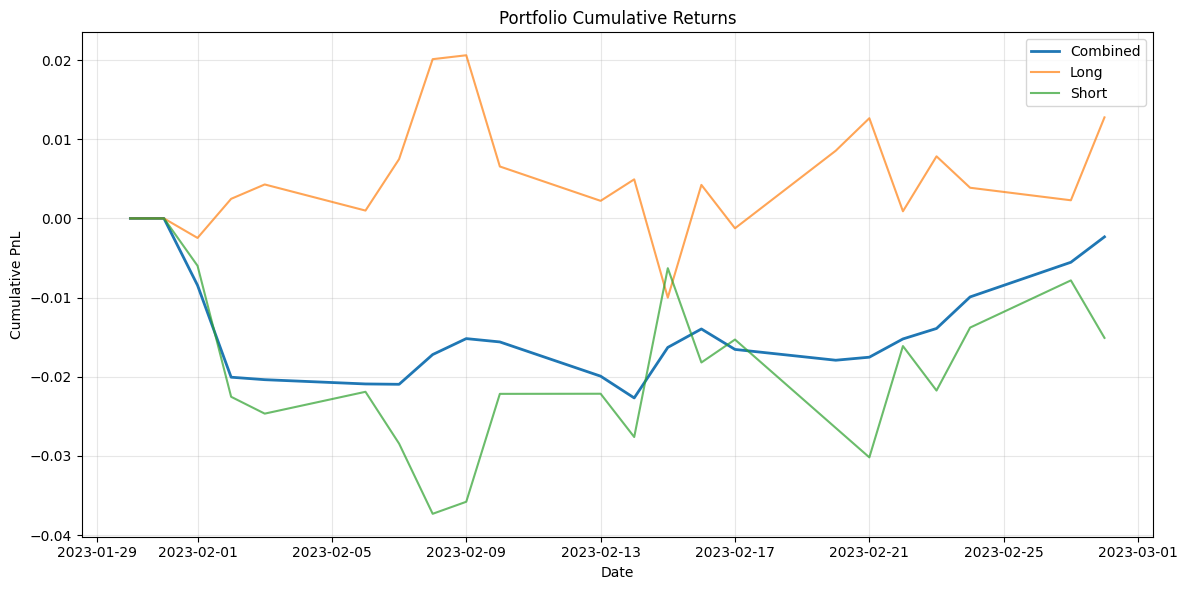

In [23]:
# 일별 수익률 합산
daily_pnl = port_returns.to_df().sum(axis=1)
long_daily_pnl = long_returns.to_df().sum(axis=1)
short_daily_pnl = short_returns.to_df().sum(axis=1)

# 누적 수익률
cum_pnl = daily_pnl.cumsum()
long_cum_pnl = long_daily_pnl.cumsum()
short_cum_pnl = short_daily_pnl.cumsum()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(cum_pnl.index, cum_pnl.values, label='Combined', linewidth=2)
plt.plot(long_cum_pnl.index, long_cum_pnl.values, label='Long', linewidth=1.5, alpha=0.7)
plt.plot(short_cum_pnl.index, short_cum_pnl.values, label='Short', linewidth=1.5, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Portfolio Cumulative Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. 성과 지표

연율화된 수익률, 변동성, 샤프 비율을 계산합니다.

In [24]:
# 성과 지표 계산 (Combined 포트폴리오)
annualized_return = daily_pnl.mean() * 252
annualized_std = daily_pnl.std() * np.sqrt(252)
sharpe_ratio = daily_pnl.mean() / daily_pnl.std() * np.sqrt(252)

print("[Performance Metrics - Combined Portfolio]")
print(f"Annualized Return: {annualized_return:.4f} ({annualized_return*100:.2f}%)")
print(f"Annualized Volatility: {annualized_std:.4f} ({annualized_std*100:.2f}%)")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"\nTotal Return: {cum_pnl.iloc[-1]:.4f} ({cum_pnl.iloc[-1]*100:.2f}%)")
print(f"Max Drawdown: {(cum_pnl - cum_pnl.cummax()).min():.4f}")

[Performance Metrics - Combined Portfolio]
Annualized Return: -0.0267 (-2.67%)
Annualized Volatility: 0.0655 (6.55%)
Sharpe Ratio: -0.41

Total Return: -0.0023 (-0.23%)
Max Drawdown: -0.0227


## 요약

이 튜토리얼에서 다룬 내용:

1. ✅ AlphaExcel 초기화 및 설정
2. ✅ 연산자 탐색 (메서드 기반 API)
3. ✅ 다양한 타입의 데이터 필드 로딩
4. ✅ 시계열 연산 (이동평균)
5. ✅ 그룹 연산 (섹터 내 순위)
6. ✅ 캐시 상속 및 히스토리 추적
7. ✅ 백테스팅 (가중치 스케일링)
8. ✅ 포트폴리오 수익률 계산
9. ✅ 롱/숏 수익률 분리 분석
10. ✅ 성과 지표 계산 및 시각화

Alpha Excel v2.0의 주요 장점:
- 🚀 즉시 실행으로 빠른 프로토타이핑
- 🎯 타입 인식 시스템으로 자동 전처리
- 💡 메서드 기반 API로 편리한 사용
- 🔍 캐시 상속으로 디버깅 용이
- ⚙️ 설정 기반 설계로 유연한 커스터마이징